In [6]:
import psycopg2;
import numpy as np;
import pandas as pd
import matplotlib.pyplot as plt;
import seaborn as sns;
import datetime
import os

# Configure visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10


conn = psycopg2.connect(
    host='localhost',
    dbname='Movies', 
    user='postgres',
    password='******',
    port='5433'
)

cur=conn.cursor()


query = 'select * from moviesdata'
df = pd.read_sql(query, conn)

df['releasedate'] = pd.to_datetime(df['releasedate'])

C:\Users\Piyush\AppData\Local\Temp\ipykernel_12112\459304.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               999999 non-null  object 
 1   title                 999999 non-null  object 
 2   genre                 999999 non-null  object 
 3   releaseyear           999999 non-null  object 
 4   releasedate           999999 non-null  object 
 5   country               999999 non-null  object 
 6   budgetusd             999999 non-null  float64
 7   us_boxofficeusd       999999 non-null  float64
 8   global_boxofficeusd   999999 non-null  float64
 9   opening_day_salesusd  999999 non-null  float64
 10  one_week_salesusd     999999 non-null  float64
 11  imdbrating            999999 non-null  float64
 12  rottentomatoesscore   999999 non-null  int64  
 13  numvotesimdb          999999 non-null  int64  
 14  numvotesrt            999999 non-null  int64  
 15  

In [ ]:
conn.close()

----------------------------------------------------------------------
SECTION 1: FINANCIAL DISTRIBUTIONS & CORRELATION
----------------------------------------------------------------------


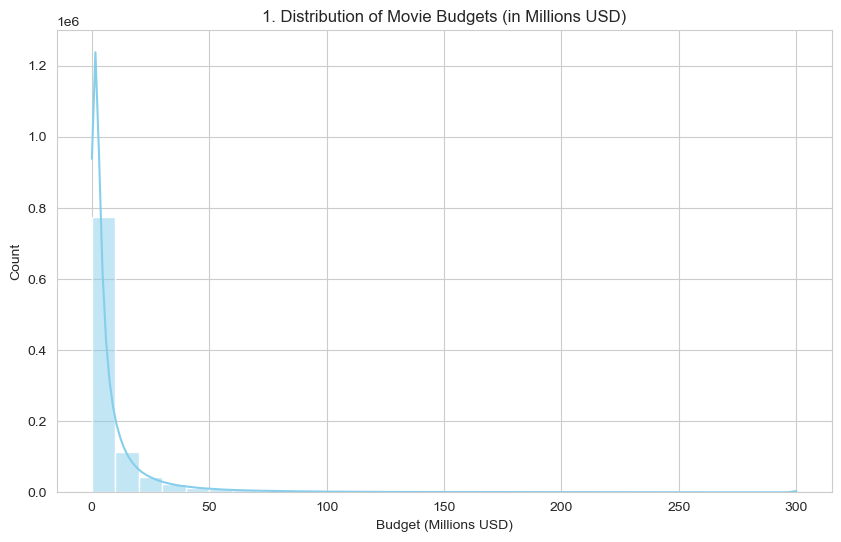

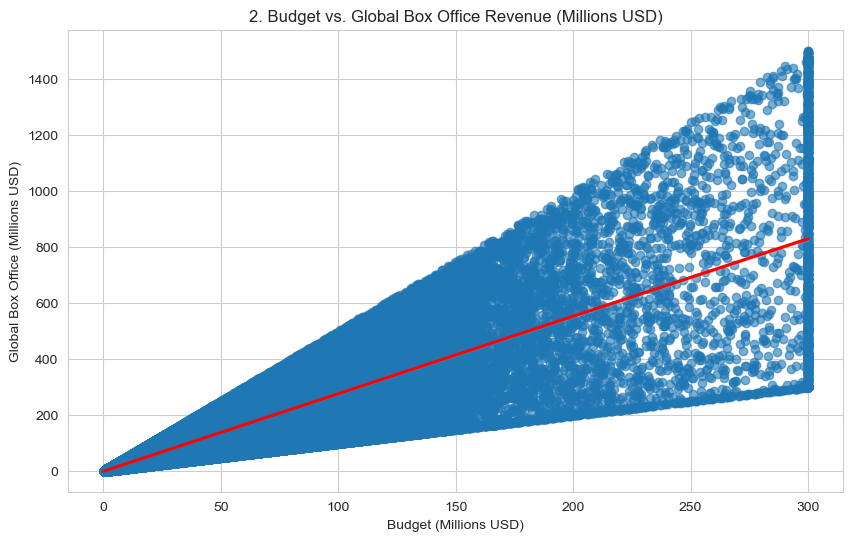


----------------------------------------------------------------------
SECTION 2: TEMPORAL AND CRITICAL TRENDS
----------------------------------------------------------------------


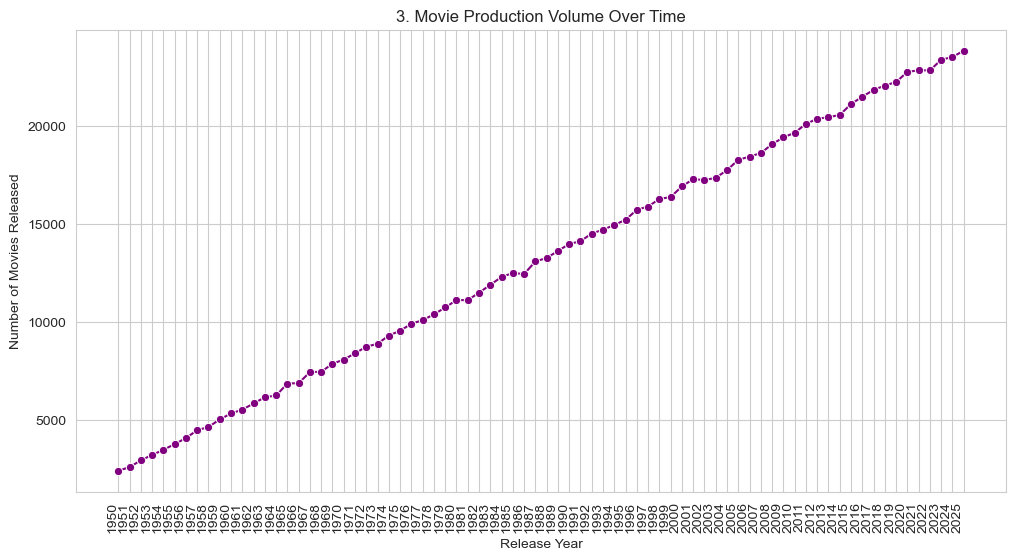

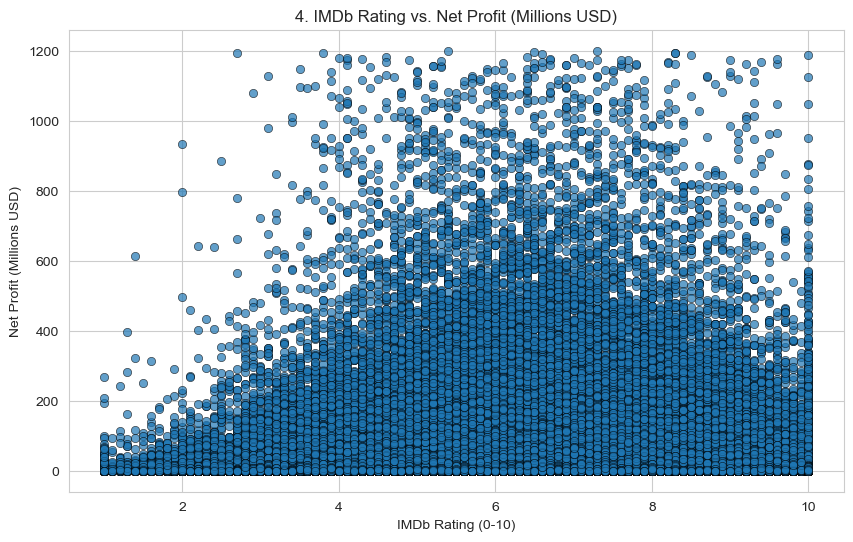

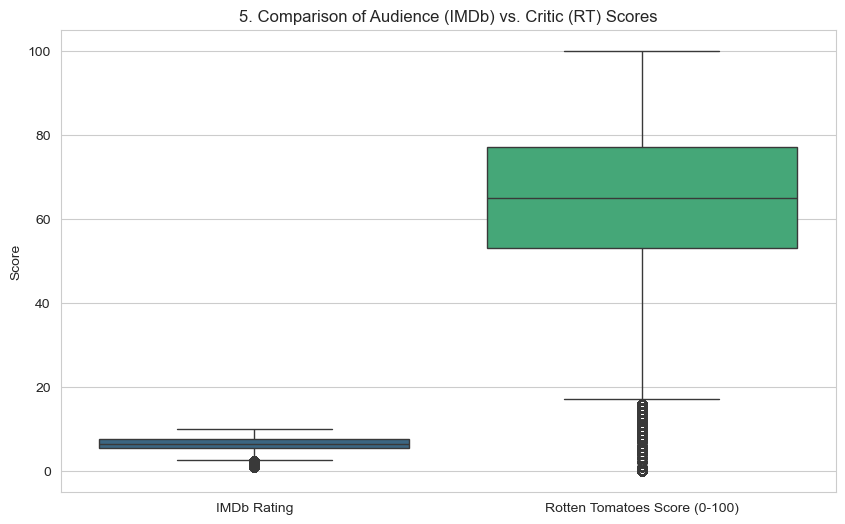

C:\Users\Piyush\AppData\Local\Temp\ipykernel_12112\1149327586.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='release_month', y='movie_count', data=monthly_releases, palette='RdYlGn')


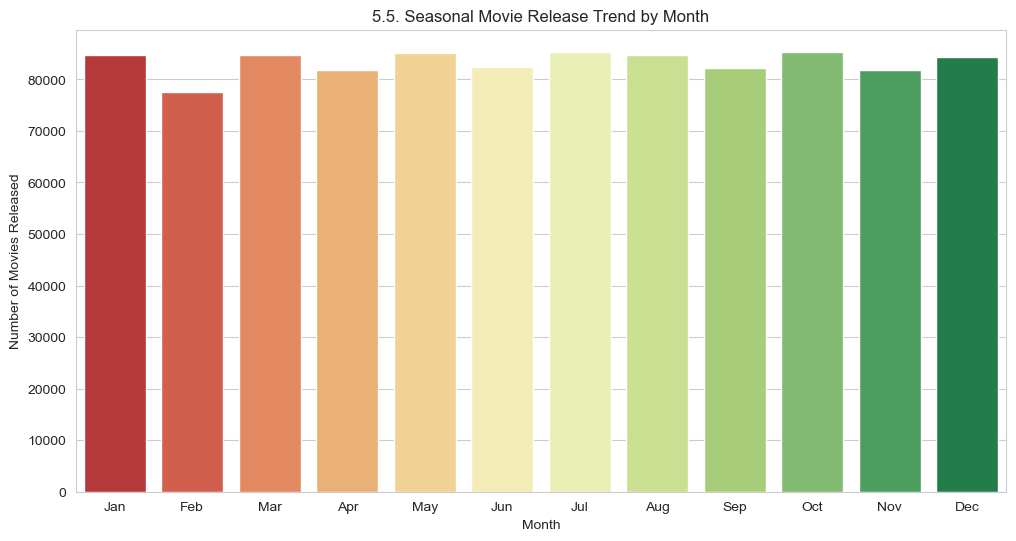


----------------------------------------------------------------------
SECTION 3: CATEGORICAL FEATURE ANALYSIS
----------------------------------------------------------------------


C:\Users\Piyush\AppData\Local\Temp\ipykernel_12112\1149327586.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_revenue.index, y=genre_revenue.values, palette='magma')


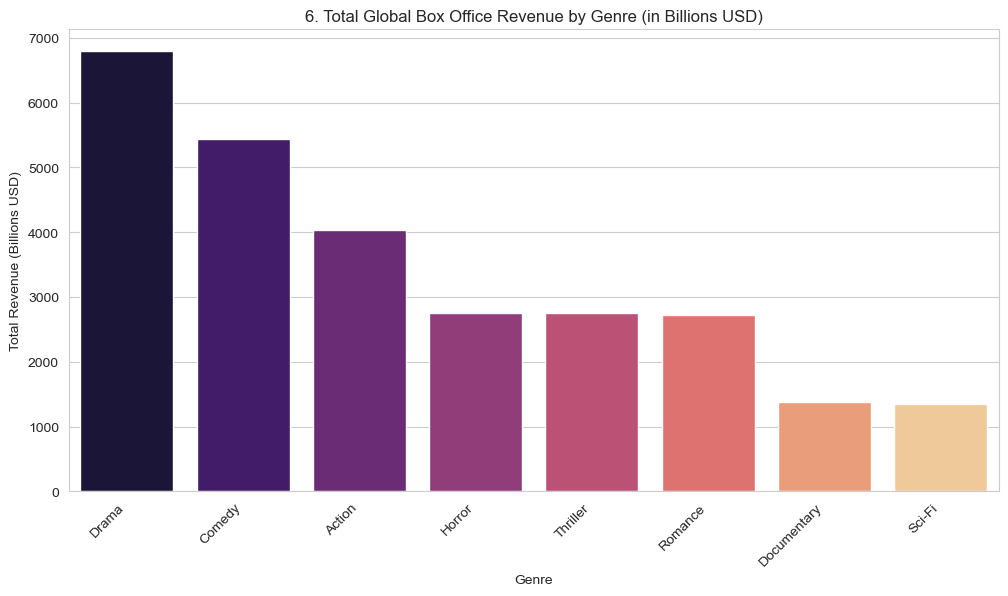

C:\Users\Piyush\AppData\Local\Temp\ipykernel_12112\1149327586.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


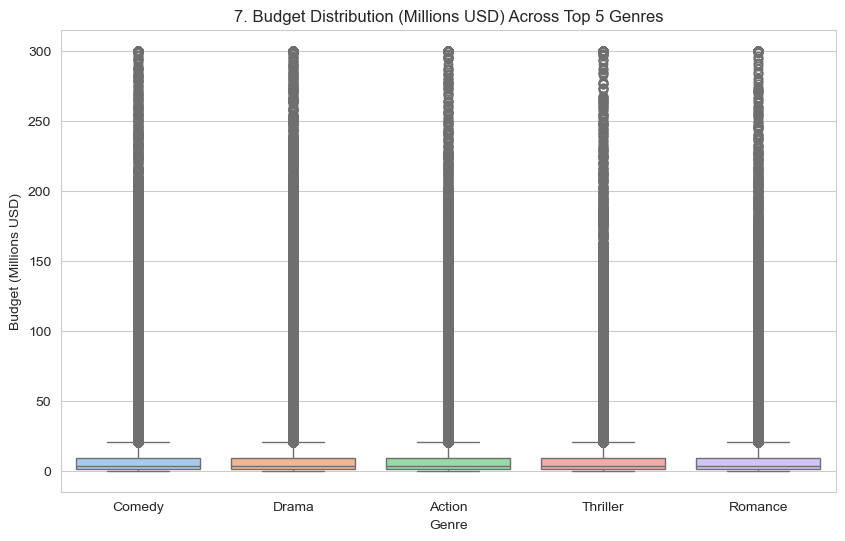

C:\Users\Piyush\AppData\Local\Temp\ipykernel_12112\1149327586.py:174: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


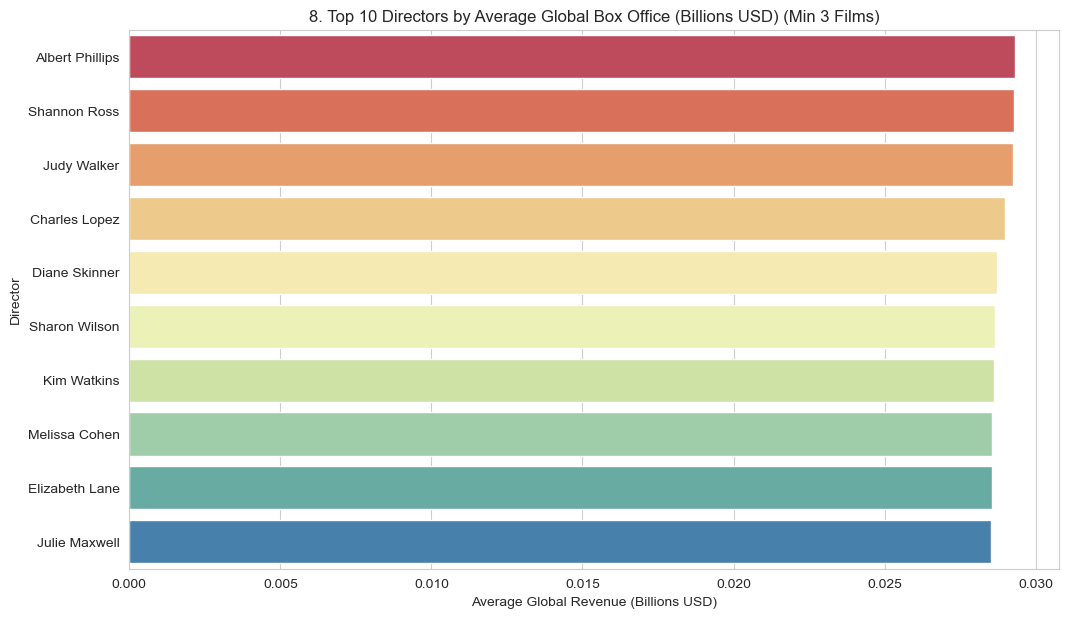


Analysis complete. All 8 charts have been generated and saved.
Check your directory: E:\Datasets\Movie Dataset for Analytics & Visualization\Charts\\


In [12]:
# --- CONFIGURATION ---
# Define the base directory for saving all charts.
# NOTE: Using 'r' prefix for raw string to handle Windows backslashes correctly.

SAVE_PATH = r'E:\Datasets\Movie Dataset for Analytics & Visualization\Charts\\'

# ##################################################################################
# ###################### DATA TRANSFORMATION: CALCULATED FIELDS ####################
# ##################################################################################

# 🌟 DERIVED COLUMN: NET PROFIT 
# We calculate Net Profit because it is a key metric for Questions 4 and 8.
# Net Profit = Global Revenue - Budget
df['net_profit'] = df['global_boxofficeusd'] - df['budgetusd']


# ##################################################################################
# ######################## SECTION 1: FINANCIAL DISTRIBUTIONS ######################
# ##################################################################################

print("-" * 70)
print("SECTION 1: FINANCIAL DISTRIBUTIONS & CORRELATION")
print("-" * 70)

# 1. QUESTION: What is the distribution of movie budgets, and where do most films fall?
# Insight: Understand the typical cost base of the movies in the dataset.
plt.figure(figsize=(10, 6))
sns.histplot(df['budgetusd'] / 1e6, kde=True, bins=30, color='skyblue')
plt.title('1. Distribution of Movie Budgets (in Millions USD)')
plt.xlabel('Budget (Millions USD)')
plt.ylabel('Count')
plt.savefig(SAVE_PATH + '1_Budget_Distribution.png', dpi=300, bbox_inches='tight')
plt.show()


# 2. QUESTION: What is the relationship between production cost (Budget) and Global Revenue?
# Insight: Determine if spending more money reliably leads to higher returns.
plt.figure(figsize=(10, 6))
sns.regplot(
    x=df['budgetusd'] / 1e6,
    y=df['global_boxofficeusd'] / 1e6,
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'},
    ci=95 # 95% confidence interval
)
plt.title('2. Budget vs. Global Box Office Revenue (Millions USD)')
plt.xlabel('Budget (Millions USD)')
plt.ylabel('Global Box Office (Millions USD)')
plt.savefig(SAVE_PATH + '2_Budget_vs_Global_Revenue.png', dpi=300, bbox_inches='tight')
plt.show()

# ##################################################################################
# ######################## SECTION 2: TEMPORAL AND CRITICAL TRENDS #################
# ##################################################################################

print("\n" + "-" * 70)
print("SECTION 2: TEMPORAL AND CRITICAL TRENDS")
print("-" * 70)

# 3. QUESTION: How has the volume of movie production changed over the years?
# Insight: Identify periods of high/low production activity.
production_trend = df.groupby('releaseyear')['movieid'].count().reset_index(name='movie_count')

plt.figure(figsize=(12, 6))
sns.lineplot(x='releaseyear', y='movie_count', data=production_trend, marker='o', color='purple')
plt.title('3. Movie Production Volume Over Time')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies Released')
plt.xticks(rotation=90, ha='right')
plt.grid(True)
plt.savefig(SAVE_PATH + '3_Production_Volume_Trend.png', dpi=300, bbox_inches='tight')
plt.show()


# 4. QUESTION: Is critical success (IMDb Rating) correlated with financial success (Net Profit)?
# Insight: Test the hypothesis that better-rated movies make more money.
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='imdbrating',
    y=df['net_profit'] / 1e6,
    data=df,
    alpha=0.7,
    edgecolor='black'
)
plt.title('4. IMDb Rating vs. Net Profit (Millions USD)')
plt.xlabel('IMDb Rating (0-10)')
plt.ylabel('Net Profit (Millions USD)')
plt.savefig(SAVE_PATH + '4_IMDb_Rating_vs_Net_Profit.png', dpi=300, bbox_inches='tight')
plt.show()


# 5. QUESTION: How do critics (Rotten Tomatoes) and the general audience (IMDb) rate movies differently?
# Insight: Compare the spread and central tendency of both rating systems.
ratings_df = df[['imdbrating', 'rottentomatoesscore']].copy()
ratings_df.columns = ['IMDb Rating', 'Rotten Tomatoes Score (0-100)']

plt.figure(figsize=(10, 6))
sns.boxplot(data=ratings_df, palette='viridis')
plt.title('5. Comparison of Audience (IMDb) vs. Critic (RT) Scores')
plt.ylabel('Score')
plt.savefig(SAVE_PATH + '5_Audience_vs_Critic_Scores.png', dpi=300, bbox_inches='tight')
plt.show()


# 5.5 QUESTION: Are there strong seasonal trends in movie releases (e.g., blockbusters in summer/holiday months)?
# Insight: Identify peak months for movie releases.
df['release_month'] = df['releasedate'].dt.month
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_releases = df.groupby('release_month')['movieid'].count().reset_index(name='movie_count')

plt.figure(figsize=(12, 6))
sns.barplot(x='release_month', y='movie_count', data=monthly_releases, palette='RdYlGn')
plt.title('5.5. Seasonal Movie Release Trend by Month')
plt.xlabel('Month')
plt.ylabel('Number of Movies Released')
plt.xticks(ticks=range(12), labels=month_names)
plt.savefig(SAVE_PATH + '5_5_Seasonal_Release_Trend.png', dpi=300, bbox_inches='tight')
plt.show()


# ##################################################################################
# ######################## SECTION 3: CATEGORICAL ANALYSIS #########################
# ##################################################################################

print("\n" + "-" * 70)
print("SECTION 3: CATEGORICAL FEATURE ANALYSIS")
print("-" * 70)

# 6. QUESTION: Which genres generate the most total revenue?
# Insight: Identify the most commercially viable genres.
genre_revenue = df.groupby('genre')['global_boxofficeusd'].sum().sort_values(ascending=False) / 1e9 # Convert to Billions

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_revenue.index, y=genre_revenue.values, palette='magma')
plt.title('6. Total Global Box Office Revenue by Genre (in Billions USD)')
plt.xlabel('Genre')
plt.ylabel('Total Revenue (Billions USD)')
plt.xticks(rotation=45, ha='right')
plt.savefig(SAVE_PATH + '6_Total_Revenue_by_Genre.png', dpi=300, bbox_inches='tight')
plt.show()


# 7. QUESTION: How does budget distribution vary across the top 5 genres?
# Insight: Determine if certain genres inherently require a larger budget (e.g., Sci-Fi vs. Drama).
top_genres = df['genre'].value_counts().nlargest(5).index
df_top_genres = df[df['genre'].isin(top_genres)]

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='genre',
    y=df_top_genres['budgetusd'] / 1e6,
    data=df_top_genres,
    palette='pastel'
)
plt.title('7. Budget Distribution (Millions USD) Across Top 5 Genres')
plt.xlabel('Genre')
plt.ylabel('Budget (Millions USD)')
plt.savefig(SAVE_PATH + '7_Budget_Distribution_by_Genre.png', dpi=300, bbox_inches='tight')
plt.show()


# 8. QUESTION: Who are the top 10 most successful directors by average global revenue?
# Insight: Identify directors who consistently deliver high-grossing films (filter for minimum 3 movies).
director_performance = df.groupby('director').agg(
    avg_revenue=('global_boxofficeusd', 'mean'),
    movie_count=('movieid', 'count')
).reset_index()

# Filter for directors with at least 3 movies
top_directors = director_performance[director_performance['movie_count'] >= 3].nlargest(10, 'avg_revenue')
top_directors['avg_revenue_b'] = top_directors['avg_revenue'] / 1e9

plt.figure(figsize=(12, 7))
sns.barplot(
    y='director',
    x='avg_revenue_b',
    data=top_directors,
    palette='Spectral'
)
plt.title('8. Top 10 Directors by Average Global Box Office (Billions USD) (Min 3 Films)')
plt.xlabel('Average Global Revenue (Billions USD)')
plt.ylabel('Director')
plt.savefig(SAVE_PATH + '8_Top_Directors_by_Avg_Revenue.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAnalysis complete. All 8 charts have been generated and saved.")
print(f"Check your directory: {SAVE_PATH}")